# **<center>Data Wrangling**

In [73]:
import os
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

from statsmodels.stats.outliers_influence import variance_inflation_factor


In [2]:
# Show all the columns in the .head() method
pd.set_option('display.max_columns', None)
# Turn all plots dark to help my eyes
plt.style.use('dark_background')

[Loan Data](https://www.kaggle.com/datasets/ranadeep/credit-risk-dataset?select=loan)

In [ ]:
# Download the data from the kaggle api
kaggle datasets download -d ranadeep/credit-risk-dataset
# unzip the data 
unzip credit-risk-dataset.zip -d credit-risk-dataset -p ./data/raw

In [3]:
# Change notebook directory back one so that it can acess the data
os.chdir('..')

In [4]:
# Load in the data with low_memory as False so that it can understand dtype
loan = pd.read_csv('./data/raw/loan.csv', low_memory = False)
# Print out the shape of the dataset
print(loan.shape)
# Print out a sample of the dataset
loan.head()

(887379, 74)


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_il_6m,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,1077501,1296599,5000.0,5000.0,4975.0,36 months,10.65,162.87,B,B2,NaN,10+ years,RENT,24000.0,Verified,Dec-2011,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/22/11 > I need to upgra...,credit_card,Computer,860xx,AZ,27.65,0.0,Jan-1985,1.0,NaN,NaN,3.0,0.0,13648.0,83.7,9.0,f,0.0,0.0,5861.071414,5831.78,5000.00,861.07,0.00,0.00,0.00,Jan-2015,171.62,NaN,Jan-2016,0.0,NaN,1.0,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1077430,1314167,2500.0,2500.0,2500.0,60 months,15.27,59.83,C,C4,Ryder,< 1 year,RENT,30000.0,Source Verified,Dec-2011,Charged Off,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/22/11 > I plan to use t...,car,bike,309xx,GA,1.00,0.0,Apr-1999,5.0,NaN,NaN,3.0,0.0,1687.0,9.4,4.0,f,0.0,0.0,1008.710000,1008.71,456.46,435.17,0.00,117.08,1.11,Apr-2013,119.66,NaN,Sep-2013,0.0,NaN,1.0,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1077175,1313524,2400.0,2400.0,2400.0,36 months,15.96,84.33,C,C5,NaN,10+ years,RENT,12252.0,Not Verified,Dec-2011,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,NaN,small_business,real estate business,606xx,IL,8.72,0.0,Nov-2001,2.0,NaN,NaN,2.0,0.0,2956.0,98.5,10.0,f,0.0,0.0,3003.653644,3003.65,2400.00,603.65,0.00,0.00,0.00,Jun-2014,649.91,NaN,Jan-2016,0.0,NaN,1.0,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1076863,1277178,10000.0,10000.0,10000.0,36 months,13.49,339.31,C,C1,AIR RESOURCES BOARD,10+ years,RENT,49200.0,Source Verified,Dec-2011,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/21/11 > to pay for prop...,other,personel,917xx,CA,20.00,0.0,Feb-1996,1.0,35.0,NaN,10.0,0.0,5598.0,21.0,37.0,f,0.0,0.0,12226.302212,12226.30,10000.00,2209.33,16.97,0.00,0.00,Jan-2015,357.48,NaN,Jan-2015,0.0,NaN,1.0,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1075358,1311748,3000.0,3000.0,3000.0,60 months,12.69,67.79,B,B5,University Medical Group,1 year,RENT,80000.0,Source Verified,Dec-2011,Current,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/21/11 > I plan on combi...,other,Personal,972xx,OR,17.94,0.0,Jan-1996,0.0,38.0,NaN,15.0,0.0,27783.0,53.9,38.0,f,766.9,766.9,3242.170000,3242.17,2233.10,1009.07,0.00,0.00,0.00,Jan-2016,67.79,Feb-2016,Jan-2016,0.0,NaN,1.0,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# Create the features dataframe
X = loan.drop('loan_status', axis = 1)
# Separate out the target variable
y = loan['loan_status']

### Categorical Columns

In [39]:
[X.dtypes.index[i] for i,type in enumerate(X.dtypes) if type not in ('int64','float64')]

['term',
 'grade',
 'sub_grade',
 'emp_title',
 'emp_length',
 'home_ownership',
 'verification_status',
 'issue_d',
 'pymnt_plan',
 'url',
 'desc',
 'purpose',
 'title',
 'zip_code',
 'addr_state',
 'earliest_cr_line',
 'initial_list_status',
 'last_pymnt_d',
 'next_pymnt_d',
 'last_credit_pull_d',
 'application_type',
 'verification_status_joint']

The term variable represents how long the period to pay the loan back. I can convert the string that has the number of months, to a integer that has the number of years.

In [6]:
X['term'] = X['term'].replace({' 36 months':3, ' 60 months':5})
X['term']

0         3
1         5
2         3
3         3
4         5
         ..
887374    3
887375    3
887376    5
887377    5
887378    3
Name: term, Length: 887379, dtype: int64

Grade is categorical variable that can be changed to a numerical variable. First I need to see what are all the possible grades are, then transfer them to numerical form, then add the subgrade to create a full grade

In [41]:
X['grade'].unique()

array(['B', 'C', 'A', 'E', 'F', 'D', 'G'], dtype=object)

There is also the subgrade column which differentiates the quality of loans within the different grades. Since there are 5 subgrades for each grade, I can convert the subgrade to .2 downgrade of the grade

In [7]:
# Convert the grades into numbers that can be analyzed
X['grade'] = X['grade'].replace({'A':7, 'B':6, 'C':5, 'D':4, 'E':3, 'F':2, 'G':1})
# Add in the subgrade as a .2 change in the grade
X['grade'] = [X['grade'][i] - ((int(sub[-1]) - 1)/5) for i, sub in enumerate(X['sub_grade'])]
# Show the grade
X['grade']

0         5.8
1         4.4
2         4.2
3         5.0
4         5.2
         ... 
887374    5.2
887375    5.2
887376    3.8
887377    2.6
887378    5.2
Name: grade, Length: 887379, dtype: float64

I can convert the employement status to an integer since it represents a numerical quantity. First I need to see all the values.

In [43]:
X['emp_length'].unique()

array(['10+ years', '< 1 year', '1 year', '3 years', '8 years', '9 years',
       '4 years', '5 years', '6 years', '2 years', '7 years', nan],
      dtype=object)

In [8]:
# Replace the non-existant values with 0
X['emp_length'] = X['emp_length'].fillna(0)
# Replace the less than one year with the average of .5
X['emp_length'] = X['emp_length'].replace('< 1 year', 0.5)
# Get rid of all non-numerical characters to convert the values into numerical
X['emp_length'] = X['emp_length'].replace(r'[a-zA-Z+]', '', regex = True)
# Change the type from string to numerical
X['emp_length'] = X['emp_length'].astype('float')

In [12]:
X['emp_length']

0         10.0
1          0.5
2         10.0
3         10.0
4          1.0
          ... 
887374     8.0
887375    10.0
887376     5.0
887377     1.0
887378    10.0
Name: emp_length, Length: 887379, dtype: float64

In [13]:
X['home_ownership'].unique()

array(['RENT', 'OWN', 'MORTGAGE', 'OTHER', 'NONE', 'ANY'], dtype=object)

In [9]:
X['home_ownership'] = X['home_ownership'].replace({'NONE': 'OTHER','ANY':'OTHER'})

In [15]:
X['purpose'].unique()

array(['credit_card', 'car', 'small_business', 'other', 'wedding',
       'debt_consolidation', 'home_improvement', 'major_purchase',
       'medical', 'moving', 'vacation', 'house', 'renewable_energy',
       'educational'], dtype=object)

In [10]:
X_num = pd.get_dummies(X, columns = ['home_ownership', 'verification_status', 'verification_status_joint', 'purpose'],
                      drop_first = True)

In [17]:
X['url'].str[:61].unique()

array(['https://www.lendingclub.com/browse/loanDetail.action?loan_id='],
      dtype=object)

In [18]:
set(X['id']) - set(X['url'].str.replace(r'\D+', '', regex = True).astype('int'))

set()

In [19]:
print(len(X['emp_title'].unique()))
X['emp_title'].value_counts()

299272


Teacher                                     13469
Manager                                     11240
Registered Nurse                             5525
Owner                                        5376
RN                                           5355
                                            ...  
Thomas J. Paul, Inc.                            1
Piggie Toes Preschool                           1
greystone park psychiatric hospital             1
Las Vegas Motropolitan Police Department        1
Manager Hotel Operations Oasis                  1
Name: emp_title, Length: 299271, dtype: int64

In [20]:
X['desc'].str.capitalize()[31:].value_counts(normalize = True)

                                                                                                                                                                                                                                                                                                                                                                       0.001952
Debt consolidation                                                                                                                                                                                                                                                                                                                                                     0.000143
  borrower added on 02/19/14 > debt consolidation<br>                                                                                                                                                                                                                   

Columns to drop:
 - **id**: This is not a relational database so there is no value in having a variable that can tie this dataset to others.
 - **member_id**: same as ID, there are no other datasets for that need a bridge variable.
 - **url**: This column is f'https://www.lendingclub.com/browse/loanDetail.action?loan_id={id}' where id is the value of the ID column for the specific row
 - **emp_title:** There are too many employment titles. People confused job type with company name so dummy encoding would be a nightmare
 - **desc:** Too many reasons for loans. Without a large Language model to process them I don't know how to evaluate all the different descriptions

In [11]:
X_num = X_num.drop(['id', 'member_id', 'url', 'desc', 'emp_title', 'title', 'zip_code','addr_state','sub_grade'], axis = 1)

In [12]:
# Convert pyment_plan to a binary variable
X_num['pymnt_plan'] = np.where(X_num['pymnt_plan'] == 'y', 1, 0)
# Convert pyment_plan to a binary variable
X_num['initial_list_status'] = np.where(X_num['initial_list_status'] == 'w', 1, 0)
# Convert pyment_plan to a binary variable
X_num['application_type'] = np.where(X_num['application_type'] == 'JOINT', 1, 0)

#### Datetime rows

In [52]:
print(X_num['issue_d'].dtype)
X_num['issue_d'].head()

object


0    Dec-2011
1    Dec-2011
2    Dec-2011
3    Dec-2011
4    Dec-2011
Name: issue_d, dtype: object

In [13]:
# Convert the issue date to a datetime object
X_num['issue_d'] = pd.to_datetime(X_num['issue_d'], errors = 'coerce')
X_num['issue_d'] = pd.to_numeric(X_num['issue_d'], errors = 'coerce')
# Convert the earliest credit line of the borrower 
X_num['earliest_cr_line'] = pd.to_datetime(X_num['earliest_cr_line'], errors = 'coerce')
X_num['earliest_cr_line'] = pd.to_numeric(X_num['earliest_cr_line'], errors = 'coerce')
# Convert the last payment date of the loan
X_num['last_pymnt_d'] = pd.to_datetime(X_num['last_pymnt_d'], errors = 'coerce')
X_num['last_pymnt_d'] = pd.to_numeric(X_num['last_pymnt_d'], errors = 'coerce')
# Convert the next payment on the loan
X_num['next_pymnt_d'] = pd.to_datetime(X_num['next_pymnt_d'], errors = 'coerce')
X_num['next_pymnt_d'] = pd.to_numeric(X_num['next_pymnt_d'], errors = 'coerce')
# Convert the date that the lending company got a credit report
X_num['last_credit_pull_d'] = pd.to_datetime(X_num['last_credit_pull_d'], errors='coerce')
X_num['last_credit_pull_d'] = pd.to_numeric(X_num['last_credit_pull_d'], errors='coerce')

In [15]:
X_num[['issue_d','earliest_cr_line','last_pymnt_d','next_pymnt_d','last_credit_pull_d']].isna().sum()

issue_d               0
earliest_cr_line      0
last_pymnt_d          0
next_pymnt_d          0
last_credit_pull_d    0
dtype: int64

Convert the term column to years instead of a string defining the amount of months the loan is for

Create a dictionary with a description of all the different columns. The column names are sometimes unintuitive so it is helpful to have this dictionary.

In [21]:
# Disable warning that openpyxl generates that is impossible to get around
warnings.filterwarnings("ignore")
# Read the dictionary in to python saved as LCDD
LCDD = pd.read_excel('./data/raw/LCDataDictionary.xlsx')
# Turn Warnings back on for the rest of the notebook
warnings.filterwarnings("always")
# Create the dictionary with the columns as keys and the descriptions as values
col_defs = dict(zip(LCDD['LoanStatNew'],LCDD['Description']))
# Show the dictionary
col_defs

{'addr_state': 'The state provided by the borrower in the loan application',
 'annual_inc': 'The self-reported annual income provided by the borrower during registration.',
 'annual_inc_joint': 'The combined self-reported annual income provided by the co-borrowers during registration',
 'application_type': 'Indicates whether the loan is an individual application or a joint application with two co-borrowers',
 'collection_recovery_fee': 'post charge off collection fee',
 'collections_12_mths_ex_med': 'Number of collections in 12 months excluding medical collections',
 'delinq_2yrs': "The number of 30+ days past-due incidences of delinquency in the borrower's credit file for the past 2 years",
 'desc': 'Loan description provided by the borrower',
 'dti': 'A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income.',
 'dti_joint': "A ratio calculated

In [54]:
X_num.nunique().sort_values(ascending = True)

policy_code                  1
application_type             2
purpose_vacation             2
home_ownership_OTHER         2
home_ownership_OWN           2
                         ...  
out_prncp_inv           266244
total_rec_int           324635
tot_cur_bal             327342
total_pymnt_inv         506616
total_pymnt             506726
Length: 81, dtype: int64

In [22]:
X_num = X_num.drop('policy_code', axis = 1)

In [56]:
y.value_counts(normalize = True)

Current                                                0.678153
Fully Paid                                             0.234086
Charged Off                                            0.050991
Late (31-120 days)                                     0.013062
Issued                                                 0.009534
In Grace Period                                        0.007047
Late (16-30 days)                                      0.002656
Does not meet the credit policy. Status:Fully Paid     0.002240
Default                                                0.001374
Does not meet the credit policy. Status:Charged Off    0.000858
Name: loan_status, dtype: float64

### Missing Values

C:\Users\jdrel\AppData\Local\Temp\ipykernel_10368\3873561872.py:7: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('log');


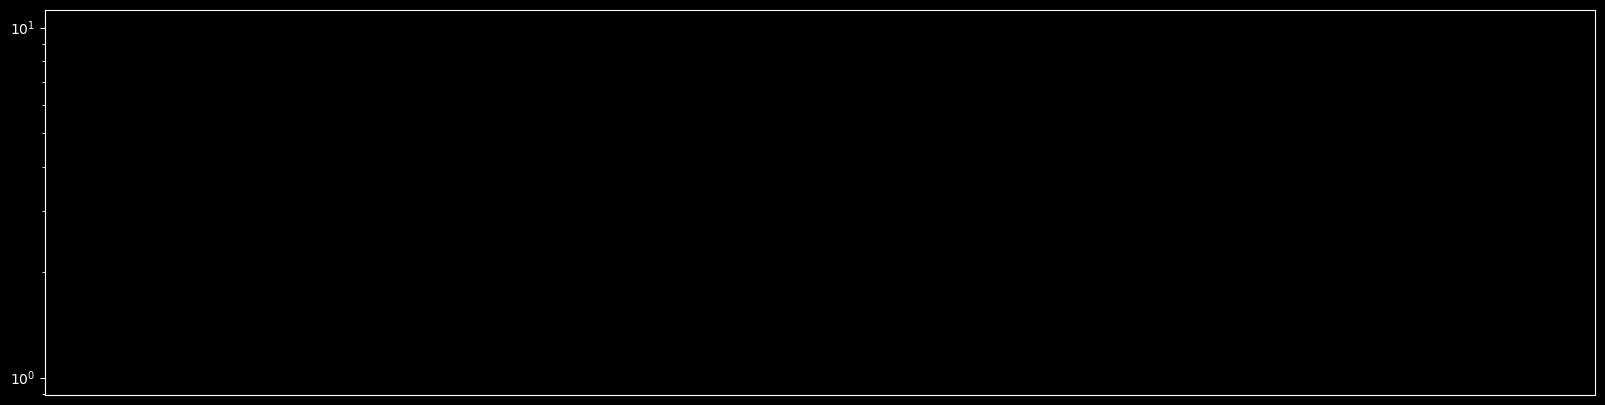

In [25]:
plt.figure(figsize = (20,5));
# Plot missing values for each column
plt.bar(x = X_num.columns, height = X_num.isna().sum()/X_num.shape[0])
# hide the names of the columns for a cleaner graph
plt.xticks([]);
# Set the scale to log so I can see every column that has a missing value
plt.yscale('log');

In [120]:
list(X_num.columns[X_num.isna().sum()/X_num.shape[0] > 0])

['annual_inc',
 'delinq_2yrs',
 'inq_last_6mths',
 'mths_since_last_delinq',
 'mths_since_last_record',
 'open_acc',
 'pub_rec',
 'revol_util',
 'total_acc',
 'collections_12_mths_ex_med',
 'mths_since_last_major_derog',
 'annual_inc_joint',
 'dti_joint',
 'acc_now_delinq',
 'tot_coll_amt',
 'tot_cur_bal',
 'open_acc_6m',
 'open_il_6m',
 'open_il_12m',
 'open_il_24m',
 'mths_since_rcnt_il',
 'total_bal_il',
 'il_util',
 'open_rv_12m',
 'open_rv_24m',
 'max_bal_bc',
 'all_util',
 'total_rev_hi_lim',
 'inq_fi',
 'total_cu_tl',
 'inq_last_12m']

In [24]:
X_num = X_num.fillna(0)

#### Multicollinearity

In [30]:
# Function to get rid of all the diagonals in correlation heatmaps
def zero_diagonal_heatmap(dfx, min = 0, max = None, color_map = None, threshhold = 0):
    # give the max a base value
    if max is None:
        max = dfx.shape[1]
    # Create a numpy matrix that is easy to manipulate
    cm = np.array(abs(dfx.iloc[:,min:max].corr(numeric_only = True)))
    # Create a loop that replaces all the diagonal values with 0
    for i in range(len(cm)):
        # Loop thorough the other axis of values
        for j in range(len(cm)):
            # All diagonal values happen when i == j
            if i == j:
                # set the diagonal value equal to 0
                cm[i,j] = 0
    df_cm = pd.DataFrame(cm, columns = list(dfx.columns)[min:max], index = list(dfx.columns)[min:max])
    # Make the plot bigger
    plt.figure(figsize=(12, 8))
    # Plot the heatmap
    ax = sns.heatmap(df_cm, cmap = color_map, center = threshhold, vmin = 0, vmax = 1);

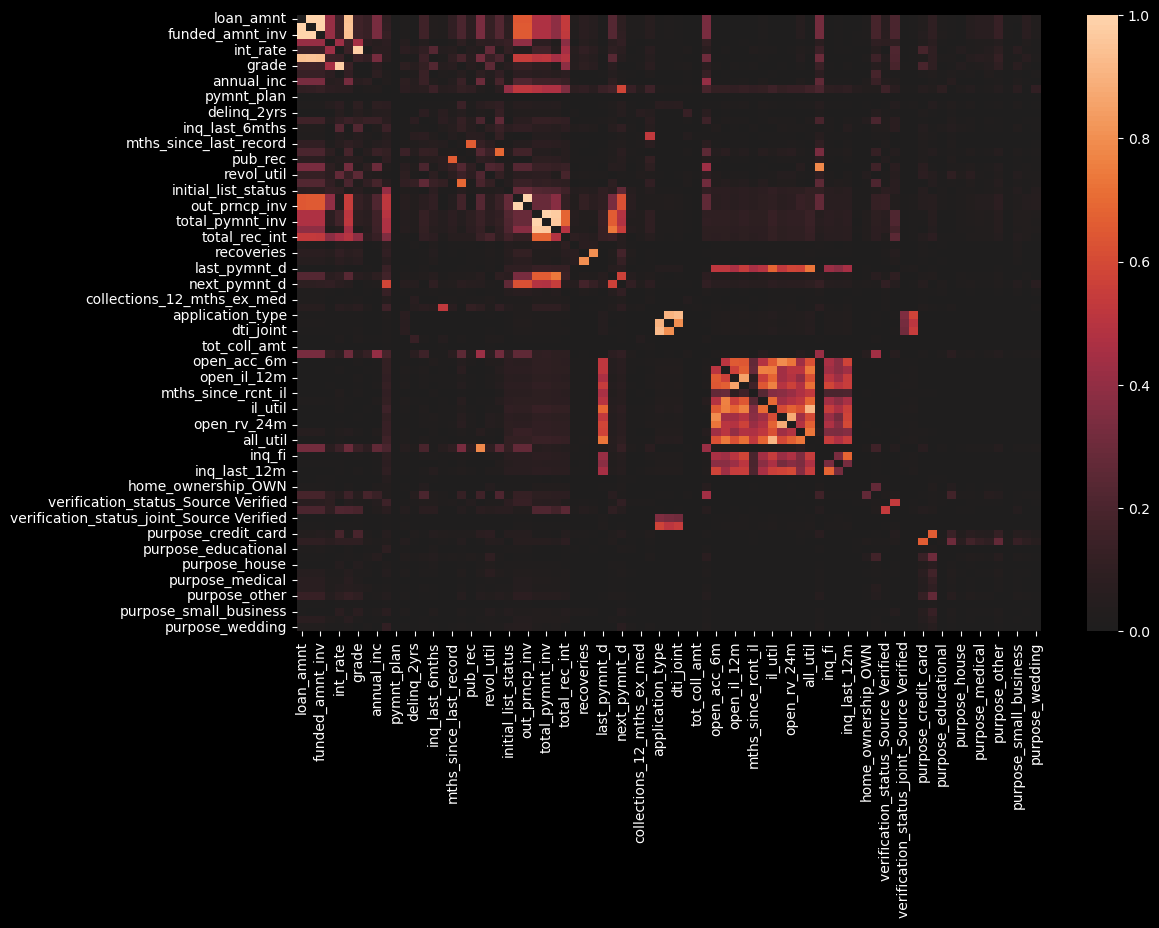

In [31]:
zero_diagonal_heatmap(X_num)

(9, 9)


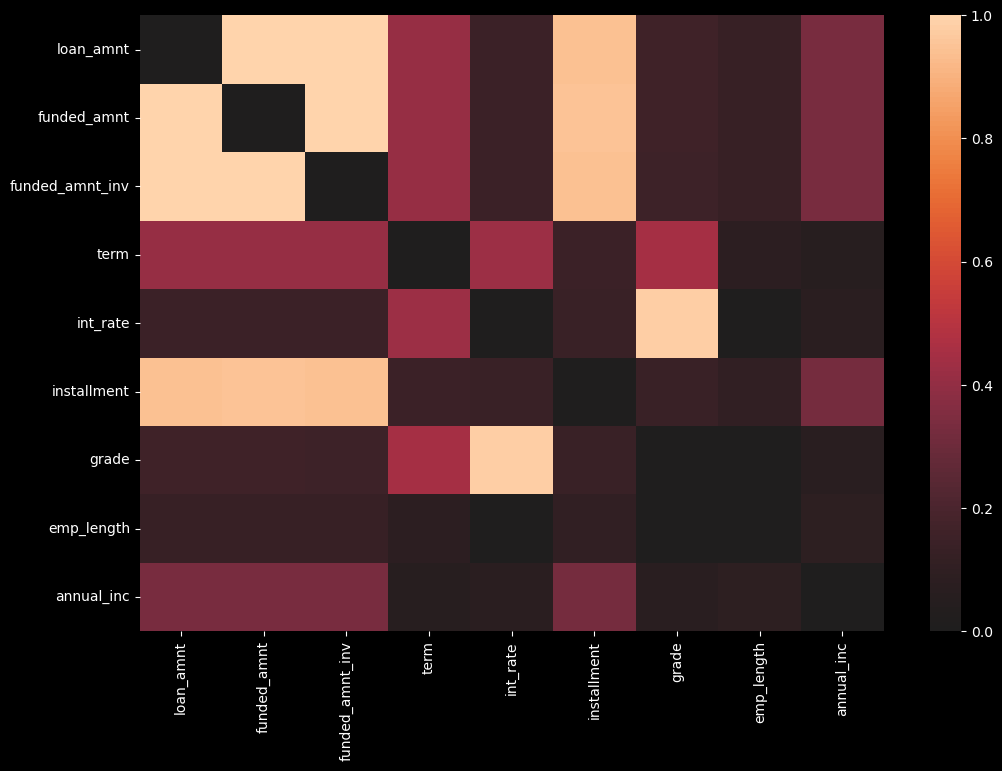

In [115]:
zero_diagonal_heatmap(X_num, 0, 9)

'loan_amnt' is the amount the requested amount of money for the loan from the borrower, 'funded_amnt' is the amount of money that has been committed to the loan, and 'funded_amnt_inv is the amount of money investors have committed to the loan. Since loan amount is the only variable that the applicant has control over, I believe it is the only relevant variable to keep. 'installment' is the monthly payment if the loan originates, this is a function of the loan amount and the term and can be dropped. 'int_rate' is the interest rate of the loan and it is directly determined by the grade that lending club gives the loan. I can pick one of the two and it will contain the information of the other.

In [58]:
X_num = X_num.drop(['funded_amnt','funded_amnt_inv', 'installment','int_rate'], axis = 1)

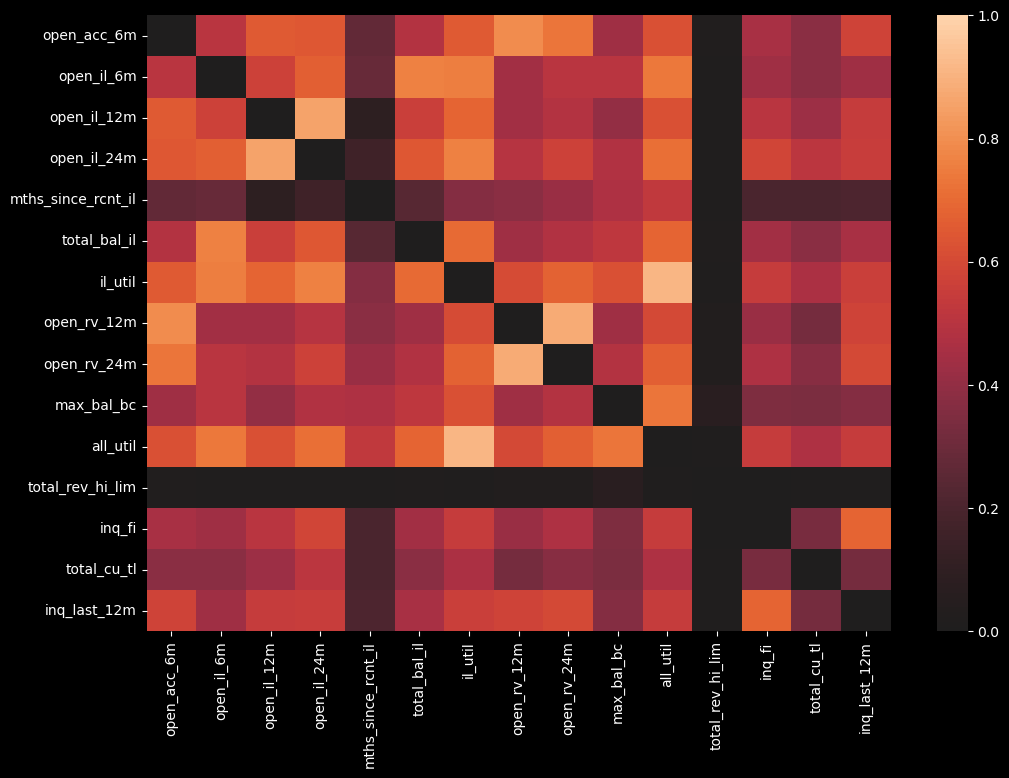

In [70]:
zero_diagonal_heatmap(X_num,40,55)

In [85]:
# Create a function that takes a dataframe and a correlation level 
def corr_dict(dfx, corr = 0.7):
    # Create the correlation with absolute values to measure collinearity
    corr_mat = abs(dfx.corr()) > corr   # type: ignore
    # Define the dictionary outside the function for uses
    global correl_dict
    # Create a dictionary with sorted values so that it is easy to see the next steps
    correl_dict = dict(corr_mat.sum().sort_values(ascending = False)) 
    # Subtract each value by one for the self correlation on the diagonal
    correl_dict = {key: value - 1 for key, value in correl_dict.items() if value != 1}
    # Print the dictionary
    print(correl_dict)

In [90]:
corr_mat = abs(X_num.corr()) > .7
print(corr_mat.loc[corr_mat['all_util']==True, 'all_util'])

last_pymnt_d    True
open_il_6m      True
open_il_24m     True
il_util         True
max_bal_bc      True
all_util        True
Name: all_util, dtype: bool


In [91]:
corr_dict(X_num)

{'all_util': 5, 'il_util': 4, 'open_il_24m': 3, 'open_il_6m': 3, 'total_rec_prncp': 3, 'dti_joint': 2, 'annual_inc_joint': 2, 'total_bal_il': 2, 'open_rv_24m': 2, 'application_type': 2, 'open_acc_6m': 2, 'open_rv_12m': 2, 'total_pymnt_inv': 2, 'total_pymnt': 2, 'last_pymnt_d': 1, 'collection_recovery_fee': 1, 'out_prncp_inv': 1, 'out_prncp': 1, 'recoveries': 1, 'total_rev_hi_lim': 1, 'revol_bal': 1, 'max_bal_bc': 1, 'open_il_12m': 1, 'last_pymnt_amnt': 1}


In [63]:
# Create a function that takes a list of features and minimum number of correlations
def corr_list(min_corr, corr, still_high_mcl = None):
    # Define the dictionary where all the information will be stored
    correlations2 = {}
    # Almost always the default value will be None
    if still_high_mcl is None:
        # # the default list is the keys from correl_dict whose values are at least min_corr
        still_high_mcl = [key for key, value in correl_dict.items() if value >= min_corr]
    # Store the correlation matrix in a variable for easy use  
    still_corr = abs(X_num[still_high_mcl].corr())
    # Put the index and column names as the feature names
    still_corr.columns = still_high_mcl
    still_corr.index = still_high_mcl
    # Iterate through all the features in the list
    for shm in still_high_mcl:
        # create a list of all the features that have a correlation of over 7
        corrs2 = still_corr.index[still_corr[shm] > corr].tolist() #type: ignore
        # remove the self correlation
        corrs2.remove(shm)
        # input the feature and list into the dictionary
        correlations2.update({shm: corrs2})
    # print the result    
    print(correlations2)

In [92]:
corr_list(corr = 0.7, min_corr = 4)

{'all_util': ['il_util'], 'il_util': ['all_util']}


To make sure that I had fully eliminated the multicollinearity I calculated every remaining feature’s Variance Inflation Factor (VIF). The formula for VIF is:
$$VIF=\frac{1}{1-R^2}$$                                                  
Where ${R^2}$ is the R-squared value that represents correlations.   

In [71]:
# Create vif function with a dataframe as the argument
def vif(dfx):
    #calculate the vif for the dataframe to see if it is non collinear
    vifs = [variance_inflation_factor(dfx.values, i) for i in range(dfx.shape[1])]
    # Put those numbers into a dictionary
    vif_dict = {dfx.columns[i]:vifs[i] for i in range(dfx.shape[1])}
    # Create a filtered dictionary to find out how many features have a VIF under 2.5
    filtered_dict = {k: v for k, v in vif_dict.items() if v < 2.5}
    # Print the amount of columns that aren't collinear out of all the columns
    print(f"{len(filtered_dict)} out of {len(dfx.columns)} features have a vif < 2.5")
    # Create a sorted dictionary based on the values
    vif_dict = {k:v for k, v in sorted(vif_dict.items(), key=lambda item: item[1], reverse = True)}
    # Print the result
    print(vif_dict)

In [74]:
vif(X_num)

52 out of 75 features have a vif < 2.5
{'issue_d': 298.8157882152313, 'last_credit_pull_d': 277.9191040107678, 'total_pymnt': 104.03373894868817, 'out_prncp': 99.48890003352875, 'out_prncp_inv': 99.41564505076349, 'total_pymnt_inv': 89.00436992310655, 'total_rec_prncp': 38.90748389169586, 'term': 20.79673583774221, 'grade': 16.16256189829736, 'earliest_cr_line': 15.630760170401318, 'loan_amnt': 11.208608735051074, 'revol_util': 8.463638538326178, 'total_acc': 6.6970348000483835, 'open_acc': 6.651136147006396, 'total_rev_hi_lim': 4.464831118746308, 'revol_bal': 4.317418506484341, 'total_rec_int': 3.6674458115862016, 'emp_length': 3.472942687447514, 'all_util': 3.1773338754127445, 'annual_inc': 2.9853574981337774, 'il_util': 2.8607661538938944, 'last_pymnt_amnt': 2.667978987955336, 'open_il_6m': 2.574945129259593, 'purpose_debt_consolidation': 2.4814653058424514, 'tot_cur_bal': 2.4471074924787506, 'next_pymnt_d': 2.409241789554425, 'last_pymnt_d': 2.259278686253214, 'dti': 2.169166706485

## <center> **Lasso Regularization**

Lasso Regularization is a technique for variable selection that uses regression to evaluate the effect that features have on a target variable. The idea is to add a penalty term that contains the coefficient or slope of the variables with respect to the target variable multiplied by parameter. 
\begin{equation}
Loss(β_1,...β_n) = SSD + \alpha|β| \nonumber
\end{equation}
Where $\beta$ is the coefficient of the feature, SSD is the sum of squared distances of the point to the regression line and $\alpha$ is the penalty’s parameter. If there is more than a single feature, then we can sum the coefficients:
\begin{equation}
Loss(β_1,...β_n) = SSD + \alpha* \sum_{i=1}^{n}|β_i| \nonumber
\end{equation}
Lasso aims to reduce the loss in equation (3). If a feature is not important, then changing its slope will not move the regression line close enough to the data points to decrease the loss function with a non-zero value. If a feature is important, the regression line will move towards the data and minimize the SSD faster than it increases the penalty term. Since only features with non-zero coefficients are meaningful, I can discard all the features with a coefficient of zero. 



First we will run a gridsearch to find the best value of $\alpha$, and then we will use the coeffecients from that value of $\alpha$ to determine which features stay in the model.

In [ ]:
# Create Lasso model
lasso = Lasso(max_iter = 50000)

# Define hyperparameter grid with a value less than 00.5 since that was the be
params = {'alpha': np.linspace(.001, .01, 20)}

# Perform grid search
grid_search = GridSearchCV(estimator=lasso, param_grid=params, cv=8)

# fit the gridsearch of parameters to the data
grid_search.fit(df, y)

# Print best hyperparameters
print("Best hyperparameters: ", grid_search.best_params_)

In [ ]:
# Find the coefficients of lasso regularization
lasso = Lasso(alpha = )
# Fit the lasso regularization to the data 
lasso.fit(df,y)
# Create a dictionary of all the features and their corresponding lasso coefficients
lasso_dict = {df.columns[i]:lasso.coef_[i] for i in range(len(df.columns)) if list(lasso.coef_)[i] != 0}
# Create a list of all the features that don't have a lasso coefficient of zero
lasso_features = [df.columns[i] for i in range(len(df.columns)) if list(lasso.coef_)[i] != 0]
# Print the features and coefficients
print(lasso_dict)
# Print the number of features are left from lasso
print(len(lasso_dict))